# Gradient Boosting Classifier

<img src="https://www.fromthegenesis.com/wp-content/uploads/2019/05/XG3.jpg">

<p>Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.
The idea of gradient boosting originated in the observation by Leo Breiman that boosting can be interpreted as an optimization algorithm on a suitable cost function. Explicit regression gradient boosting algorithms were subsequently developed by Jerome H. Friedman, simultaneously with the more general functional gradient boosting perspective of Llew Mason, Jonathan Baxter, Peter Bartlett and Marcus Frean. The latter two papers introduced the view of boosting algorithms as iterative functional gradient descent algorithms. That is, algorithms that optimize a cost function over function space by iteratively choosing a function (weak hypothesis) that points in the negative gradient direction. This functional gradient view of boosting has led to the development of boosting algorithms in many areas of machine learning and statistics beyond regression and classification.
</p>
<p>Here we are going to implement gradient boosting classifier using Telecom Churn Dataset.</p>

In [1]:
print()
print(format('Recipe for Data Science Competition - DSC_Recipe_6','*^65'))
print(format('Classification with OpenML telco Churn dataset using scikit-learn gradient boosting & Monte Carlo Cross Validation', '*^95'))    
print(format('Package: scikit-learn ','*^65'))            
print(format('Model: Gradient Boosting Model','*^65'))            
print(format('DataSet: OpenML telco Churn Dataset', '*^65'))    
print(format('Model selection: using Monte Carlo Cross Validation (MCCV) / Repeated Random Sub-Sampling Validation (RRSSV)', '*^95'))       


*******Recipe for Data Science Competition - DSC_Recipe_6********
Classification with OpenML telco Churn dataset using scikit-learn gradient boosting & Monte Carlo Cross Validation
*********************Package: scikit-learn **********************
*****************Model: Gradient Boosting Model******************
***************DataSet: OpenML telco Churn Dataset***************
Model selection: using Monte Carlo Cross Validation (MCCV) / Repeated Random Sub-Sampling Validation (RRSSV)


## 0. Loading required libraries

In [2]:
import time
import pandas as pd
import pickle as pk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder    
start_time = time.time()

## 1. Helper modules for Descriptive Statistics

In [5]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [6]:
def get_top_abs_correlations(df, n=5): 
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [7]:
def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j), 
                X.corr().loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],
                columns=['pairs','corr'])
    print(df.sort_values(by='corr',ascending=False))
    print()

In [8]:
# Helper module for Label Encoding for Categorical Features
def dummyEncode(df):
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

## 2. Loading dataset

In [9]:
def load_dataset(filename):
        
    dataset = pd.read_csv(filename, sep = ',')
        
    print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
    print(dataset.dtypes)
        
    feature_names = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
    target = 'Churn'
        
    dataset = dummyEncode(dataset[['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
    'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
    'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
    'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code', 'Churn']])
        
    return feature_names, target, dataset

## 3. Find missing values in dataset if exists

In [10]:
    def find_miising_value(feature_names, target, dataset):
        
        print()
        print('#---------------------------------------------------------------')
        print('Check for Mising Value or NaN Value in the Dataset')
        print('#---------------------------------------------------------------')
        # Method - 1
        # Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Method - 2
        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))

        if (feature_count):
            print()
            print("Features with NaN => {}".format(list(dataset.columns[dataset.isnull().sum() != 0])))
            print('Count Number of Missing Value on Each Column: ')        
            print(dataset[dataset.columns[dataset.isnull().sum() != 0]].isnull().sum().sort_values(ascending = False))

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove constant columns in the Dataset')
        print('#---------------------------------------------------------------')
        colsToRemove = []
        for col in dataset.columns:
            if col not in ['Churn']:
                if dataset[col].std() == 0: 
                    colsToRemove.append(col)
        print()
        print("Removed `{}` Constant Columns: ".format(len(colsToRemove)))
        print(colsToRemove)
        # remove constant columns in the Dataset
        dataset.drop(colsToRemove, axis=1, inplace=True)

        print()
        print('#---------------------------------------------------------------')
        print('Check and Remove Duplicate Columns in the Dataset')
        print('#---------------------------------------------------------------')
        print()
        print(dataset.columns); print(dataset.head(5))
        print('\nDuplicate Columns in the Dataset: \n', dataset.columns.duplicated())        
        dataset = dataset.loc[:, ~dataset.columns.duplicated()]
        print()
        print(dataset.columns); print(dataset.head(5))
        
        print()
        print('#---------------------------------------------------------------')
        print('Check and Drop Sparse Data/Columns in the Dataset')
        print('#---------------------------------------------------------------')
        flist = [x for x in dataset.columns if not x in ['Class', 'Class']]
        print(); print(flist)
        for f in flist:
            if len(np.unique(dataset[f])) < 2:
                print('Feature contains Sparse Data: ', f)
                dataset.drop(f, axis=1, inplace=True)
        print()
        print(dataset.columns); print(dataset.head(5))
        
        # --------------------------------------------------
        # Missing Values treatment in the DataSet (if any)
        # --------------------------------------------------    

        # Filling NULL values according to their dataTypes
        # Group Dataset according to different dataTypes
        gd = dataset.columns.to_series().groupby(dataset.dtypes).groups
        print('\nGroup Columns according to their dataTypes: \n', gd)  
        colNames = dataset.columns.values.tolist()
        for colName in colNames:
            if dataset[colName].dtypes == 'int64':
                dataset[colName] = dataset[colName].fillna(0)
            if dataset[colName].dtypes == 'float64':
                dataset[colName] = dataset[colName].fillna(0.0) 
            if dataset[colName].dtypes == 'object':
                dataset[colName] = dataset[colName].fillna('Unknown')    

        ## Count Number of Missing Value on Each Column    
        print('\nCount Number of Missing Value on Each Column: ')        
        print(dataset.isnull().sum(axis=0))

        # Check if there are any missing values in Dataset
        feature_count = dataset.columns[dataset.isnull().sum() != 0].size
        print()
        print("Total Features with missing Values = " + str(feature_count))
        
        return(dataset)

## 4. Descriptive statistics and correlation matrix

In [11]:
    def data_descriptiveStats(feature_names, target, dataset):
        # Count Number of Missing Value on Each Column    
        print(); print('Count Number of Missing Value on Each Column: ')        
        print(); print(dataset[feature_names].isnull().sum(axis=0))
        print(); print(dataset[target].isnull().sum(axis=0))    
    
        # Get Information on the feature variables
        print(); print('Get Information on the feature variables: ')            
        print(); print(dataset[feature_names].info())
        print(); print(dataset[feature_names].describe())
    
        # correlation
        pd.set_option('precision', 2)
        print(); print(dataset[feature_names].corr())    
    
        # Ranking of Correlation Coefficients among Variable Pairs
        print(); print("Ranking of Correlation Coefficients:")    
        corrank(dataset[feature_names])

        # Print Highly Correlated Variables
        print(); print("Highly correlated variables (Absolute Correlations):")
        print(); print(get_top_abs_correlations(dataset[feature_names], 8))
    
        # Get Information on the target    
        print(); print(dataset[target].describe())    
        print(); print(dataset.groupby(target).size())

## 5. Data visualisation and correlation graph

In [12]:
    def data_visualization(feature_names, target, dataset):
        # BOX plots USING box and whisker plots
        i = 1
        print(); print('BOX plot of each numerical features')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=True, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].plot(kind='box', subplots=True, sharex=False, sharey=False)
            i += 1
        plt.show()    
    
        # USING histograms
        j = 1
        print(); print('Histogram of each Numerical Feature')
        plt.figure(figsize=(11,9))     
        for col in feature_names:
            plt.subplot(5,4,j)
            plt.axis('on')
            plt.tick_params(axis='both', left=True, top=False, right=False, bottom=False, 
                            labelleft=False, labeltop=False, labelright=False, labelbottom=False)
            dataset[col].hist()
            j += 1
        plt.show()

        # correlation matrix
        print(); print('Correlation Matrix of All Numerical Features')   
        fig = plt.figure(figsize=(11,9))
        ax = fig.add_subplot(111)
        cax = ax.matshow(dataset[feature_names].corr(), vmin=-1, vmax=1, interpolation='none')
        fig.colorbar(cax)
        ticks = np.arange(0,19,1)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        plt.show()

        # Correlation Plot using seaborn
        print(); print("Correlation plot of Numerical features")
        # Compute the correlation matrix
        corr = dataset[feature_names].corr()
        print(corr)
        # Generate a mask for the upper triangle
        mask = np.zeros_like(corr, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9))
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin= -1.0, center=0, square=True, 
                    linewidths=.5, cbar_kws={"shrink": .5})
        plt.show()    
    
        # Pie chart for Categorical Variables
        print(); print('PIE Chart of for Target: ')
        plt.figure(figsize=(11,9)) 
        i = 1
        for colName in [target]:
            labels = []; sizes = [];
            df = dataset.groupby(colName).size()
            for key in df.keys():
                labels.append(key)
                sizes.append(df[key])
            # Plot PIE Chart with %
            plt.subplot(2,2,i)
            plt.axis('on')
            plt.tick_params(axis='both', left=False, top=False, right=False, bottom=False, 
                            labelleft=True, labeltop=True, labelright=False, labelbottom=False)        
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
            plt.axis('equal')
            i += 1; plt.savefig('Piefig.pdf', format='pdf')
        plt.show()  

## 6. Data split to train and test datasets

In [13]:
    def data_split(feature_names, target, dataset):
        # Data Transform - Split train : test datasets
        X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, feature_names], 
                                                            dataset.loc[:, target], test_size=0.05)
        return X_train, X_test, y_train, y_test

In [14]:
    def training_model(X_train, y_train):

        _value = []; _model = []; _best_features = [];

        # Create different Feature subsets
        F1 = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
              'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
              'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
              'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
        F2 = [
              'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
              'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
              'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
        F3 = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 

              'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
              'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
        F4 = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
              'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',

              'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
        F5 = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
              'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
              'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
              ]
        
        F6 = ['Account_Length', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
              'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
              'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code']
        
        F7 = ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 
              'Night_Mins','Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan',
              'Day_Calls', 'Day_Charge', 'Intl_Charge', 'State', 'Area_Code']
        
        subsets_sum = [F1] + [F2] + [F3] + [F4] + [F5] + [F6] + [F7]
        
        print(subsets_sum)
        
        # Twelve random sates randomly choosen for the outer-MCCV
        for i in [32,41,45,52,65,72,96,97,112,114,128,142]:
            print ('\n\nRandom state : ', i)
            
            model = GradientBoostingClassifier(random_state=i, n_estimators=200)

            #  Split the dataset into two stratified parts, 80% for Outer training set
            X1_train, X1_test, y1_train, y1_test = train_test_split(X_train, y_train, 
                                                train_size=0.8, random_state=i, stratify=y_train)

            # Choose k-fold cross-validation technique for the inner loop
            inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)

            # Set temporary variables
            best_subset = []
            best_auc = -np.inf

            # Loop over the features combinations
            for subset in subsets_sum:
                score = cross_val_score(model, X=X1_train[subset], y=y1_train, 
                                        cv = inner_cv.split(X1_train[subset], y1_train), 
                                        scoring='accuracy')
                if score.mean() > best_auc:
                    best_auc = score.mean()
                    best_subset = subset

            # Train the model on the Outer training set with the selected feature combination
            model = model.fit(X1_train[best_subset], y1_train)
            
            # Calculate the predicted labels with the model on the Outer test set with the selected feature combination
            y1_pred = model.predict(X1_test[best_subset])
            
            # Calculate the accuracy between predicted and true labels
            acc = accuracy_score(y1_test, y1_pred)
            print('Selected features:', best_subset,'; Outer Test ACC: ',acc)
            
            _best_features.append(best_subset); _value.append(acc); _model.append(model); 
        
        
        print(); print(_value)
        print(); print('Maximum Accuracy Index: ', np.argmax(_value))
        
        idx = np.argmax(_value)
        print("\nBest model parameters with random_state:");    print(_model[idx])
        print("\nBest feature combination:");    print(_best_features[idx])
        print("\nBest accuracy from MCCV:");    print(_value[idx])
        
        return(_model[idx], _best_features[idx])

In [18]:
    def evaluate_model(model, features, X_train, y_train, X_test, y_test):
        
        print()
        print(model.get_params(deep=True))
        
        # Evaluate the skill of the Trained model
        pred_Class          = model.predict(X_test[features])
        acc                 = accuracy_score(y_test, pred_Class)
        classReport         = classification_report(y_test, pred_Class)
        confMatrix          = confusion_matrix(y_test, pred_Class) 
        kappa_score         = cohen_kappa_score(y_test, pred_Class)         
        
        print(); print('Evaluation of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)

        pred_proba = model.predict_proba(X_test[features])
        
        # Add more plots here using scikit-plot
        # ROC curves
        skplt.metrics.plot_roc(y_test,pred_proba,figsize=(9,9)); plt.show()

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(y_test,pred_Class,figsize=(9,9)); plt.show()        

        # precision recall curve
        skplt.metrics.plot_precision_recall(y_test, pred_proba, 
                title='Precision-Recall Curve', plot_micro=True, 
                classes_to_plot=None, ax=None, figsize=(9,9), 
                cmap='nipy_spectral', title_fontsize='large', 
                text_fontsize='medium'); plt.show()
        
        # Add more ... ... ...
        
        # plot learning Curves
        skplt.estimators.plot_learning_curve(model, X_train[features], y_train, figsize=(6,6))
        plt.show()
        
        return model

In [17]:
    def featureRank_Analysis(model, dataset, cols):
        print()
        print("Feature Importance/Rank Analysis: ")
        X = dataset.loc[:, cols]; X_cols = X.columns.values
    
        features_imp = model.feature_importances_    
    
        indices = np.argsort(features_imp)[::-1]
        df = {}
        for f in range(X.shape[1]):
            print("%d. feature %d %s (%f)" % (f + 1, indices[f], X_cols[indices[f]], 
                                              features_imp[indices[f]]))
            df[f] = [f + 1, indices[f], X_cols[indices[f]], features_imp[indices[f]]]

        df1 = pd.DataFrame.from_dict(df, orient = 'index')
        df1.columns = ['feature_Rank', 'feature_Index', 'feature_Name', 'feature_importance']
        df1.to_csv("FeatureImportanceRank.csv", index = False)

        # this creates a figure 5 inch wide, 3 inch high
        plt.figure(figsize=(11,11)) 
        plt.barh(df1['feature_Rank'], df1['feature_importance'], tick_label = df1['feature_Name'])
        plt.savefig('Featurefig.pdf', format='pdf')
        plt.show()   

        skplt.estimators.plot_feature_importances(model, feature_names=cols,
                                                  x_tick_rotation = 90, figsize=(11,11))
        plt.show()

## 7. Make Prediction

In [19]:
    def save_model(model):
        with open('DSC_Recipe_6_model.pickle', 'wb') as f: 
            pk.dump(model, f)

In [20]:
    def final_prediction(feature_names, filename):
        # load model
        f = open('DSC_Recipe_6_model.pickle', 'rb')
        model = pk.load(f); f.close();
        
        # load dataset
        dataset = pd.read_csv(filename, sep = ',')

        print(dataset.shape);    print(dataset.head(5));    print(dataset.columns);
        print(dataset.dtypes)
        
        dataset = dummyEncode(dataset)
        
        # final prediction and results
        predicted_class     = model.predict(dataset[feature_names])
        pred_proba          = model.predict_proba(dataset[feature_names])        
        dataset['predicted_class'] = predicted_class

        # Evaluate the skill of the Trained model
        acc                 = accuracy_score(dataset['Churn'], predicted_class)
        classReport         = classification_report(dataset['Churn'], predicted_class)
        confMatrix          = confusion_matrix(dataset['Churn'], predicted_class) 
        kappa_score         = cohen_kappa_score(dataset['Churn'], predicted_class)         
        
        print(); print('Testing Results of the trained model: ')
        print(); print('Accuracy : ', acc)
        print(); print('Kappa Score : ', kappa_score)
        print(); print('Confusion Matrix :\n', confMatrix)
        print(); print('Classification Report :\n',classReport)
        
        # ROC curves
        skplt.metrics.plot_roc(dataset['Churn'],pred_proba,figsize=(7,7)); plt.show()

        # Confusion matrix
        skplt.metrics.plot_confusion_matrix(dataset['Churn'],
                                            predicted_class,figsize=(7,7)); plt.show()        

        # precision recall curve
        skplt.metrics.plot_precision_recall(dataset['Churn'], pred_proba, 
                title='Precision-Recall Curve', plot_micro=True, 
                classes_to_plot=None, ax=None, figsize=(7,7), 
                cmap='nipy_spectral', title_fontsize='large', 
                text_fontsize='medium'); plt.show()               
        
        dataset.to_csv('FinalResult.csv', index = False, 
                       columns = ['Churn', 'predicted_class'])

## 8. Execute algorithm using functions above


Execution Time 1599250010.666778 seconds: 
(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charge

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


                           pairs  corr
42        (Day_Mins, Day_Charge)  1.00
59        (Eve_Mins, Eve_Charge)  1.00
75    (Night_Mins, Night_Charge)  1.00
90      (Intl_Mins, Intl_Charge)  1.00
24   (Vmail_Message, Vmail_Plan)  0.96
..                           ...   ...
103      (CustServ_Calls, State) -0.03
33        (Vmail_Message, State) -0.03
68       (Night_Mins, Intl_Plan) -0.03
111    (Intl_Plan, Night_Charge) -0.03
124          (Vmail_Plan, State) -0.03

[171 rows x 2 columns]


Highly correlated variables (Absolute Correlations):

Day_Mins       Day_Charge      1.00
Eve_Mins       Eve_Charge      1.00
Night_Mins     Night_Charge    1.00
Intl_Mins      Intl_Charge     1.00
Vmail_Message  Vmail_Plan      0.96
Intl_Plan      Day_Charge      0.05
Day_Mins       Intl_Plan       0.05
Intl_Plan      Area_Code       0.05
dtype: float64

count    3333.00
mean        0.14
std         0.35
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Churn,

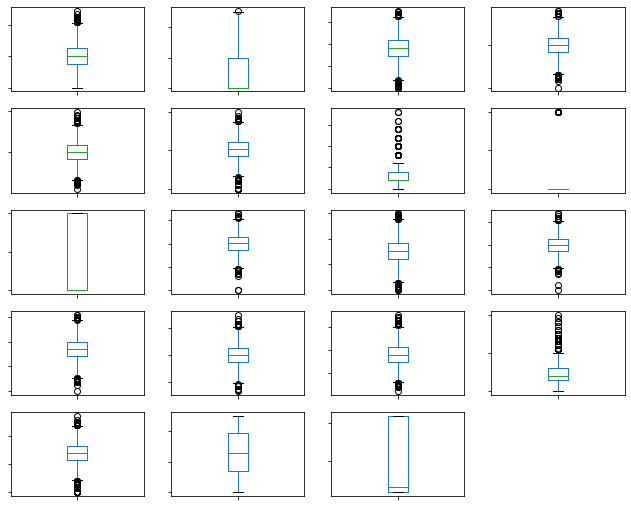


Histogram of each Numerical Feature


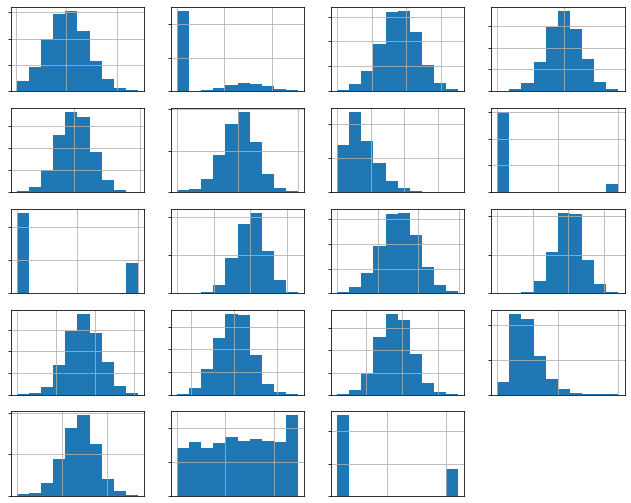


Correlation Matrix of All Numerical Features


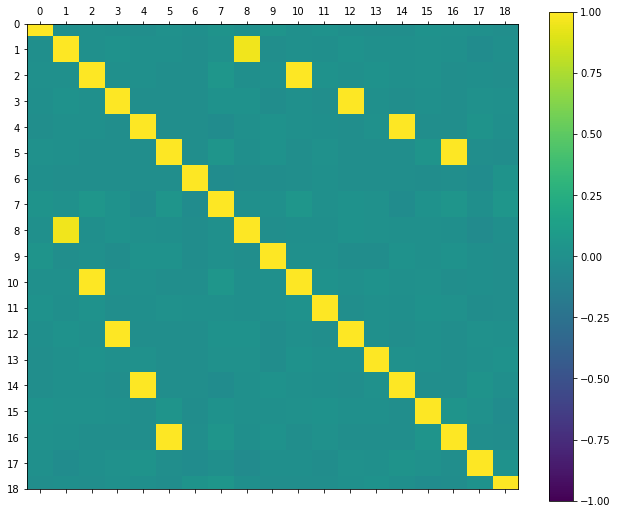


Correlation plot of Numerical features
                Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  \
Account_Length        1.00e+00      -4.63e-03  6.22e-03 -6.76e-03   -8.96e-03   
Vmail_Message        -4.63e-03       1.00e+00  7.78e-04  1.76e-02    7.68e-03   
Day_Mins              6.22e-03       7.78e-04  1.00e+00  7.04e-03    4.32e-03   
Eve_Mins             -6.76e-03       1.76e-02  7.04e-03  1.00e+00   -1.26e-02   
Night_Mins           -8.96e-03       7.68e-03  4.32e-03 -1.26e-02    1.00e+00   
Intl_Mins             9.51e-03       2.86e-03 -1.02e-02 -1.10e-02   -1.52e-02   
CustServ_Calls       -3.80e-03      -1.33e-02 -1.34e-02 -1.30e-02   -9.29e-03   
Intl_Plan             2.47e-02       8.75e-03  4.94e-02  1.91e-02   -2.89e-02   
Vmail_Plan            2.92e-03       9.57e-01 -1.68e-03  2.15e-02    6.08e-03   
Day_Calls             3.85e-02      -9.55e-03  6.75e-03 -2.15e-02    2.29e-02   
Day_Charge            6.21e-03       7.76e-04  1.00e+00  7.05e-03    

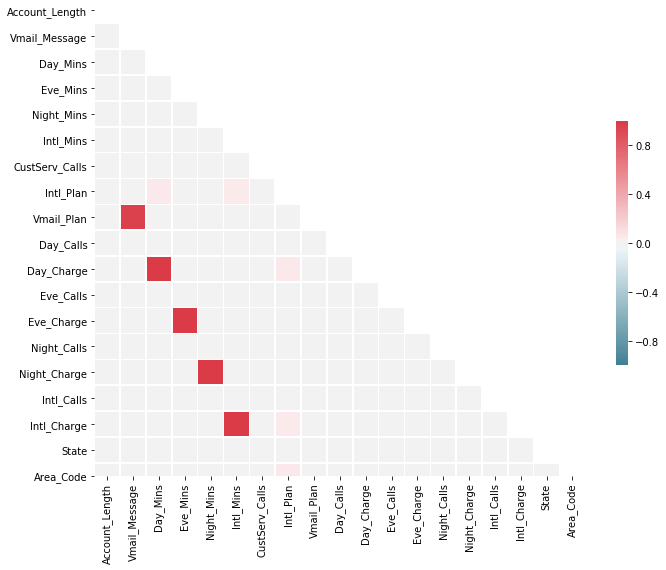


PIE Chart of for Target: 


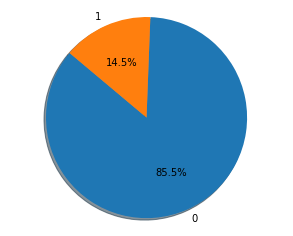

[['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code'], ['Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code'], ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code'], ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmail_Plan', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'State', 'Area_Code'], ['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins', 'Intl_Mins', 'CustServ_Calls', 'Intl_Plan', 'Vmai

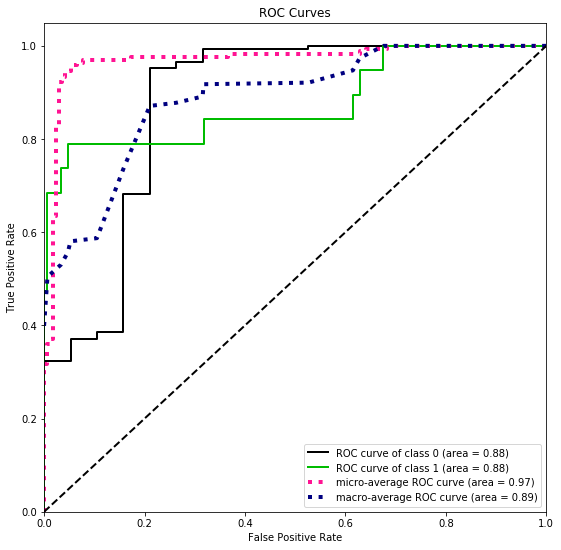

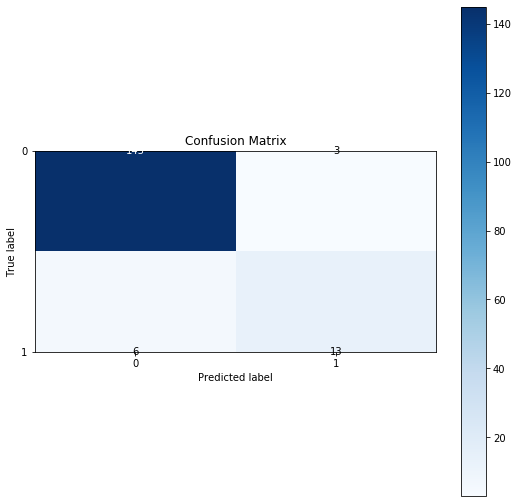

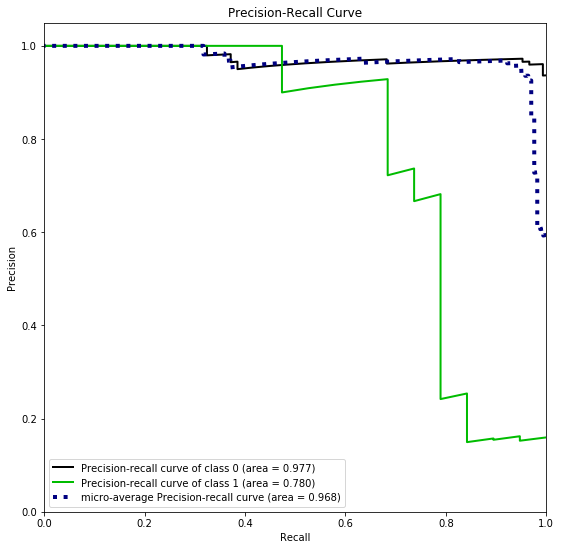

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


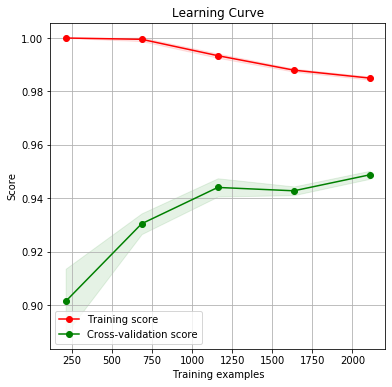


Feature Importance/Rank Analysis: 
1. feature 5 Day_Charge (0.287528)
2. feature 1 CustServ_Calls (0.165051)
3. feature 7 Eve_Charge (0.135668)
4. feature 2 Intl_Plan (0.108213)
5. feature 11 Intl_Charge (0.081794)
6. feature 10 Intl_Calls (0.077254)
7. feature 3 Vmail_Plan (0.071976)
8. feature 9 Night_Charge (0.033737)
9. feature 4 Day_Calls (0.009415)
10. feature 0 Account_Length (0.008006)
11. feature 8 Night_Calls (0.007065)
12. feature 12 State (0.007061)
13. feature 6 Eve_Calls (0.006927)
14. feature 13 Area_Code (0.000306)


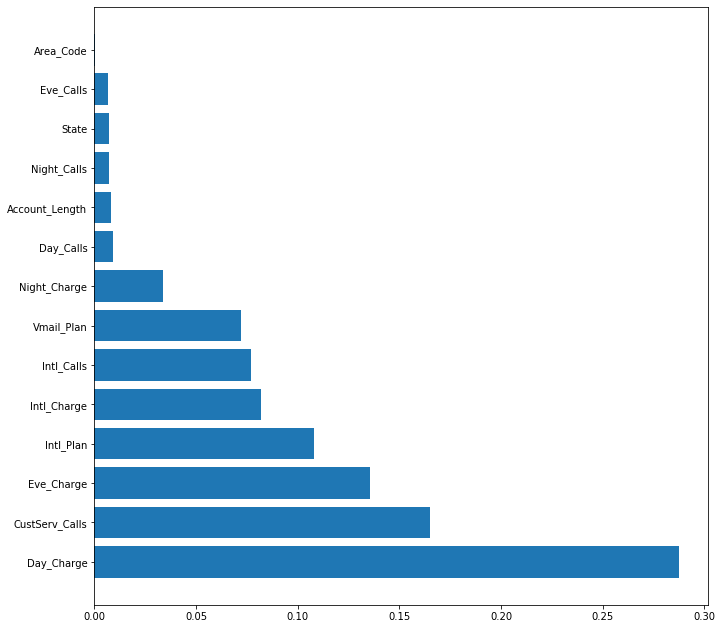

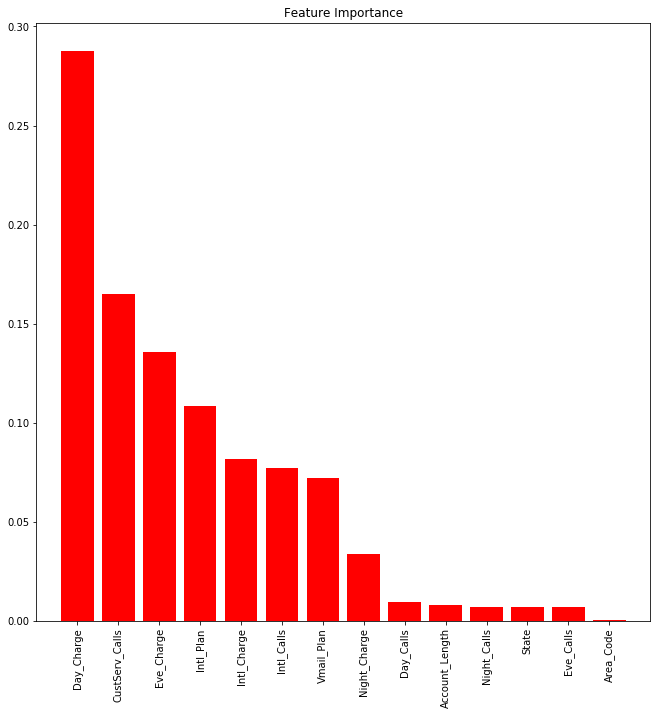

(3333, 21)
   Account_Length  Vmail_Message  Day_Mins  Eve_Mins  Night_Mins  Intl_Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ_Calls Churn Intl_Plan Vmail_Plan  ...  Day_Charge  Eve_Calls  \
0               1    no        no        yes  ...       45.07         99   
1               1    no        no        yes  ...       27.47        103   
2               0    no        no         no  ...       41.38        110   
3               2    no       yes         no  ...       50.90         88   
4               3    no       yes         no  ...       28.34        122   

   Eve_Charge  Night_Calls  Night_Charge  Intl_Calls  Int

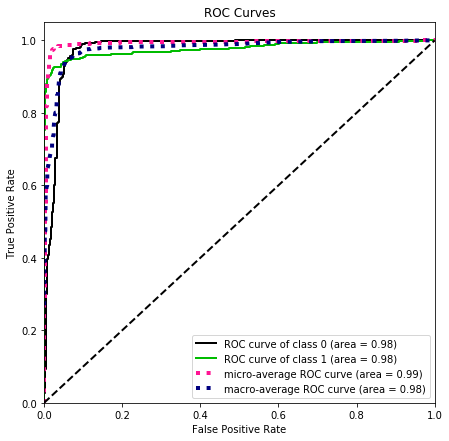

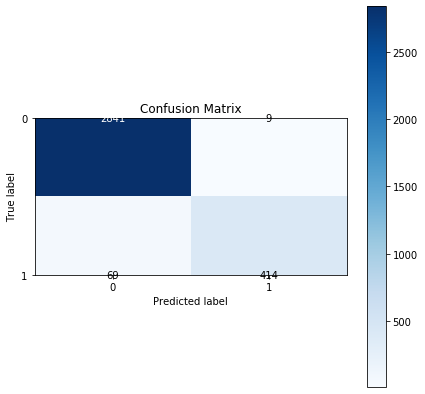

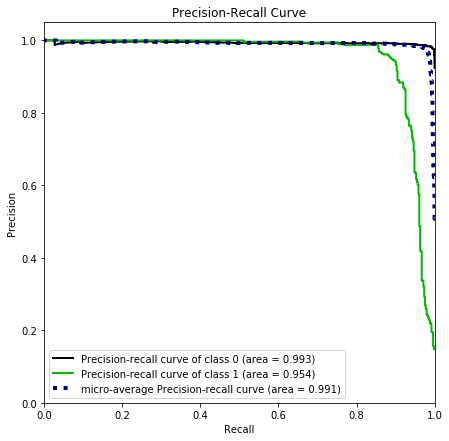


Execution Time 655.3345448970795 seconds: 


In [21]:
    if __name__ == '__main__':
        print()
        print("Execution Time %s seconds: " % (start_time))
        filename = 'TelcoCustomerChurnDataset.csv'
        
        feature_names, target, dataset = load_dataset(filename)
        dataset = find_miising_value(feature_names, target, dataset)
        data_descriptiveStats(feature_names, target, dataset)
        data_visualization(feature_names, target, dataset)
        X_train, X_test, y_train, y_test = data_split(feature_names, target, dataset)
        model, features = training_model(X_train, y_train)
        model = evaluate_model(model, features, X_train, y_train, X_test, y_test)
        featureRank_Analysis(model, dataset, features)
        save_model(model) 
        
        test_filename = 'TelcoCustomerChurnDataset.csv'
        final_prediction(features, test_filename)
        
        print()
        print("Execution Time %s seconds: " % (time.time() - start_time))

## References 

<ol>
    <li><a href="https://en.wikipedia.org/wiki/Gradient_boosting">Gradient Boosting Classifier</a></li>
</ol>